In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from gridworld.environment import WindyGridworld
from tensorflow import keras
from tqdm.notebook import tqdm
import pandas as pd
import copy


## Learning $\pi_b$ from $\mathcal{D} = \{s,a,s',r\}$

In [2]:
def load_dataset_and_trajectories(filename):
    npz = np.load(filename, allow_pickle=True)
    print(npz.files)
    return npz['centroids'], npz['clusters'], npz['trajectories'], npz['rewards'], npz['unique_concepts'], npz['concepts'], npz['actions']

means, clusters, trajectories, rewards, unique_concepts, concepts, actions = load_dataset_and_trajectories("saved_data/dataset_epsilon_large_more_concepts.npz") #We're using dataset_large and dataset_knn
print(trajectories.shape)
print(rewards.shape)
print(unique_concepts.shape)
print(concepts.shape)
print(actions.shape)
print(means.shape)
print(clusters.shape)

from sklearn.neighbors import KNeighborsClassifier
import numpy as np

num_concepts = len(means)
examples_per_concept = int(len(clusters)/num_concepts)
print(examples_per_concept)
# Load some example data
X_train = np.array(clusters)
y_train = np.repeat(np.linspace(0, num_concepts, num_concepts, endpoint=False), examples_per_concept)
X_test = np.array([[1,1], [3,3],[0,-2]])


# Create a kNN classifier with k=3
knn = KNeighborsClassifier(n_neighbors=10) #smaller k values results in more fluctuation of the concepts

# Train the classifier
knn.fit(X_train, y_train)


env = WindyGridworld(num_concepts=num_concepts, method="knn", knn=knn, means=means, policy_model=None, custom_policy=None)

['centroids', 'clusters', 'trajectories', 'rewards', 'unique_concepts', 'concepts', 'actions']
(5438,)
(5438,)
(5438,)
(5438,)
(5438,)
(10, 2)
(500, 2)
50


# Data pre-processing

In [3]:
A = env.A

def generate_default_dataset(window_size, concept_mapping=None, concept_path=None):
    actions_indexed = actions_to_action_indexes(np.concatenate(actions))
    Y = actions_indexed.reshape(len(actions_indexed), 1)
    # Y = np.concatenate(actions)
    X = np.concatenate(window_states(trajectories, W_s=window_size))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, 4), to_categorical(y_test, 4)

def window_states(trajectories, W_s=30):
    '''Replaces each state with the average value of previous W_s states including the current state, smoothing the trajectories.'''
    windowed_trajectories = []
    for traj in trajectories:
        windowed_traj = np.zeros((len(traj), 2))
        for i in range(1, len(traj)+1):
            window = traj[i - min(W_s, i):i]
            windowed_traj[i-1] = np.sum(window, axis=0)/len(window)
        windowed_trajectories.append(windowed_traj)
    return np.array(windowed_trajectories, dtype='object')

def actions_to_action_indexes(actions):
    '''Returns the index of the action in the state space, e.g. 0 for up, 1 for right etc'''
    indicies = [np.where(np.all((A == a), axis=1))[0][0] for a in actions]
    return np.array(indicies)

## Learning $\pi_b$

### $\pi_b(a|\hat{s})$
Here $\hat{s}$ is the average state over a window of previous states of length $W_s$.
For use in vanilla IS.

In [4]:
# from models.policy import PolicyModel

# X_train, X_test, y_train, y_test = generate_default_dataset(window_size=5)
# print(X_train.shape)
# print(y_train.shape)
# pi_b = PolicyModel(input_size=X_train[0].shape, num_actions=4, loss="mse").build()
# history = pi_b.fit(X_train, y_train, epochs=6, batch_size=32, validation_split=0.2, verbose = 1)
# pi_b.save("saved_models/pi_b_10_reg")
pi_b = keras.models.load_model("saved_models/pi_b_10") 

In [47]:
# pi_b_reg = keras.models.load_model("saved_models/pi_b_express") 
# point = [2,2]
# print("softmax ", pi_b.predict(np.array(point).reshape(1,2))[0])
# print("Regression ", pi_b_reg.predict(np.array(point).reshape(1,2))[0])

pi_b = keras.models.load_model("saved_models/pi_b_10") 
# pi_b_reg = keras.models.load_model("saved_models/pi_b_10_reg") 


In [17]:
point = np.array([[2,1]])
print(pi_b.predict(point))
print(pi_b_reg.predict(point))

[[0.44135895 0.07609059 0.38473898 0.09781145]]
[[0.46699023 0.07361497 0.35824516 0.0966363 ]]


In [ ]:
fig, ax2 = plt.subplots(figsize=(16,8))

env.policy_model = pi_b #set policy of agent in the environment

for y in np.linspace(-3,2,2):
    print(y)
    history = env.play(True, [], [], [], [], [], s = np.array([-3, y]))
    print(len(history))
    plt.plot(history[:, 0], history[:, 1])

rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
ax2.add_patch(rect)

for i in range(num_concepts):
    start = i*100
    end = (i+1)*100
    plt.scatter(clusters[start:end,0], clusters[start:end,1], label=f"Cluster {i}")

plt.legend()
plt.title("Trajectory through Windy Gridworld")
plt.show()

### $\pi_b(a|c=f(\hat{s}))$
For use in concept IS. Can also just use default policy used to generate data, inherent to the dataset $\mathcal{D}$, but would like to try both.

In [6]:
# from models.policy import PolicyModel

# X_train, X_test, y_train, y_test = generate_default_dataset(window_size=5)
# #conver to concepts here
# concept_model = keras.models.load_model("saved_models/c_10|s")
# Xc_train = concept_model.predict(X_train)
# Xc_test = concept_model.predict(X_test)
# pi_b_c = PolicyModel(input_size=Xc_train[0].shape, num_actions=4, loss="mse").build()
# history = pi_b_c.fit(Xc_train, y_train, epochs=6, batch_size=32, validation_split=0.2, verbose = 1)
# pi_b_c.save("saved_models/pi_b_c_10_reg")
concept_model = keras.models.load_model("saved_models/c_10|s")
pi_b_c = keras.models.load_model("saved_models/pi_b_c_10")

In [20]:
h = .01  # step size in the mesh
x_min, x_max = -4, 5
y_min, y_max = -4.5,5.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.argmax(concept_model.predict(np.c_[xx.ravel(), yy.ravel()]), axis=1)
Z = Z.reshape(xx.shape)

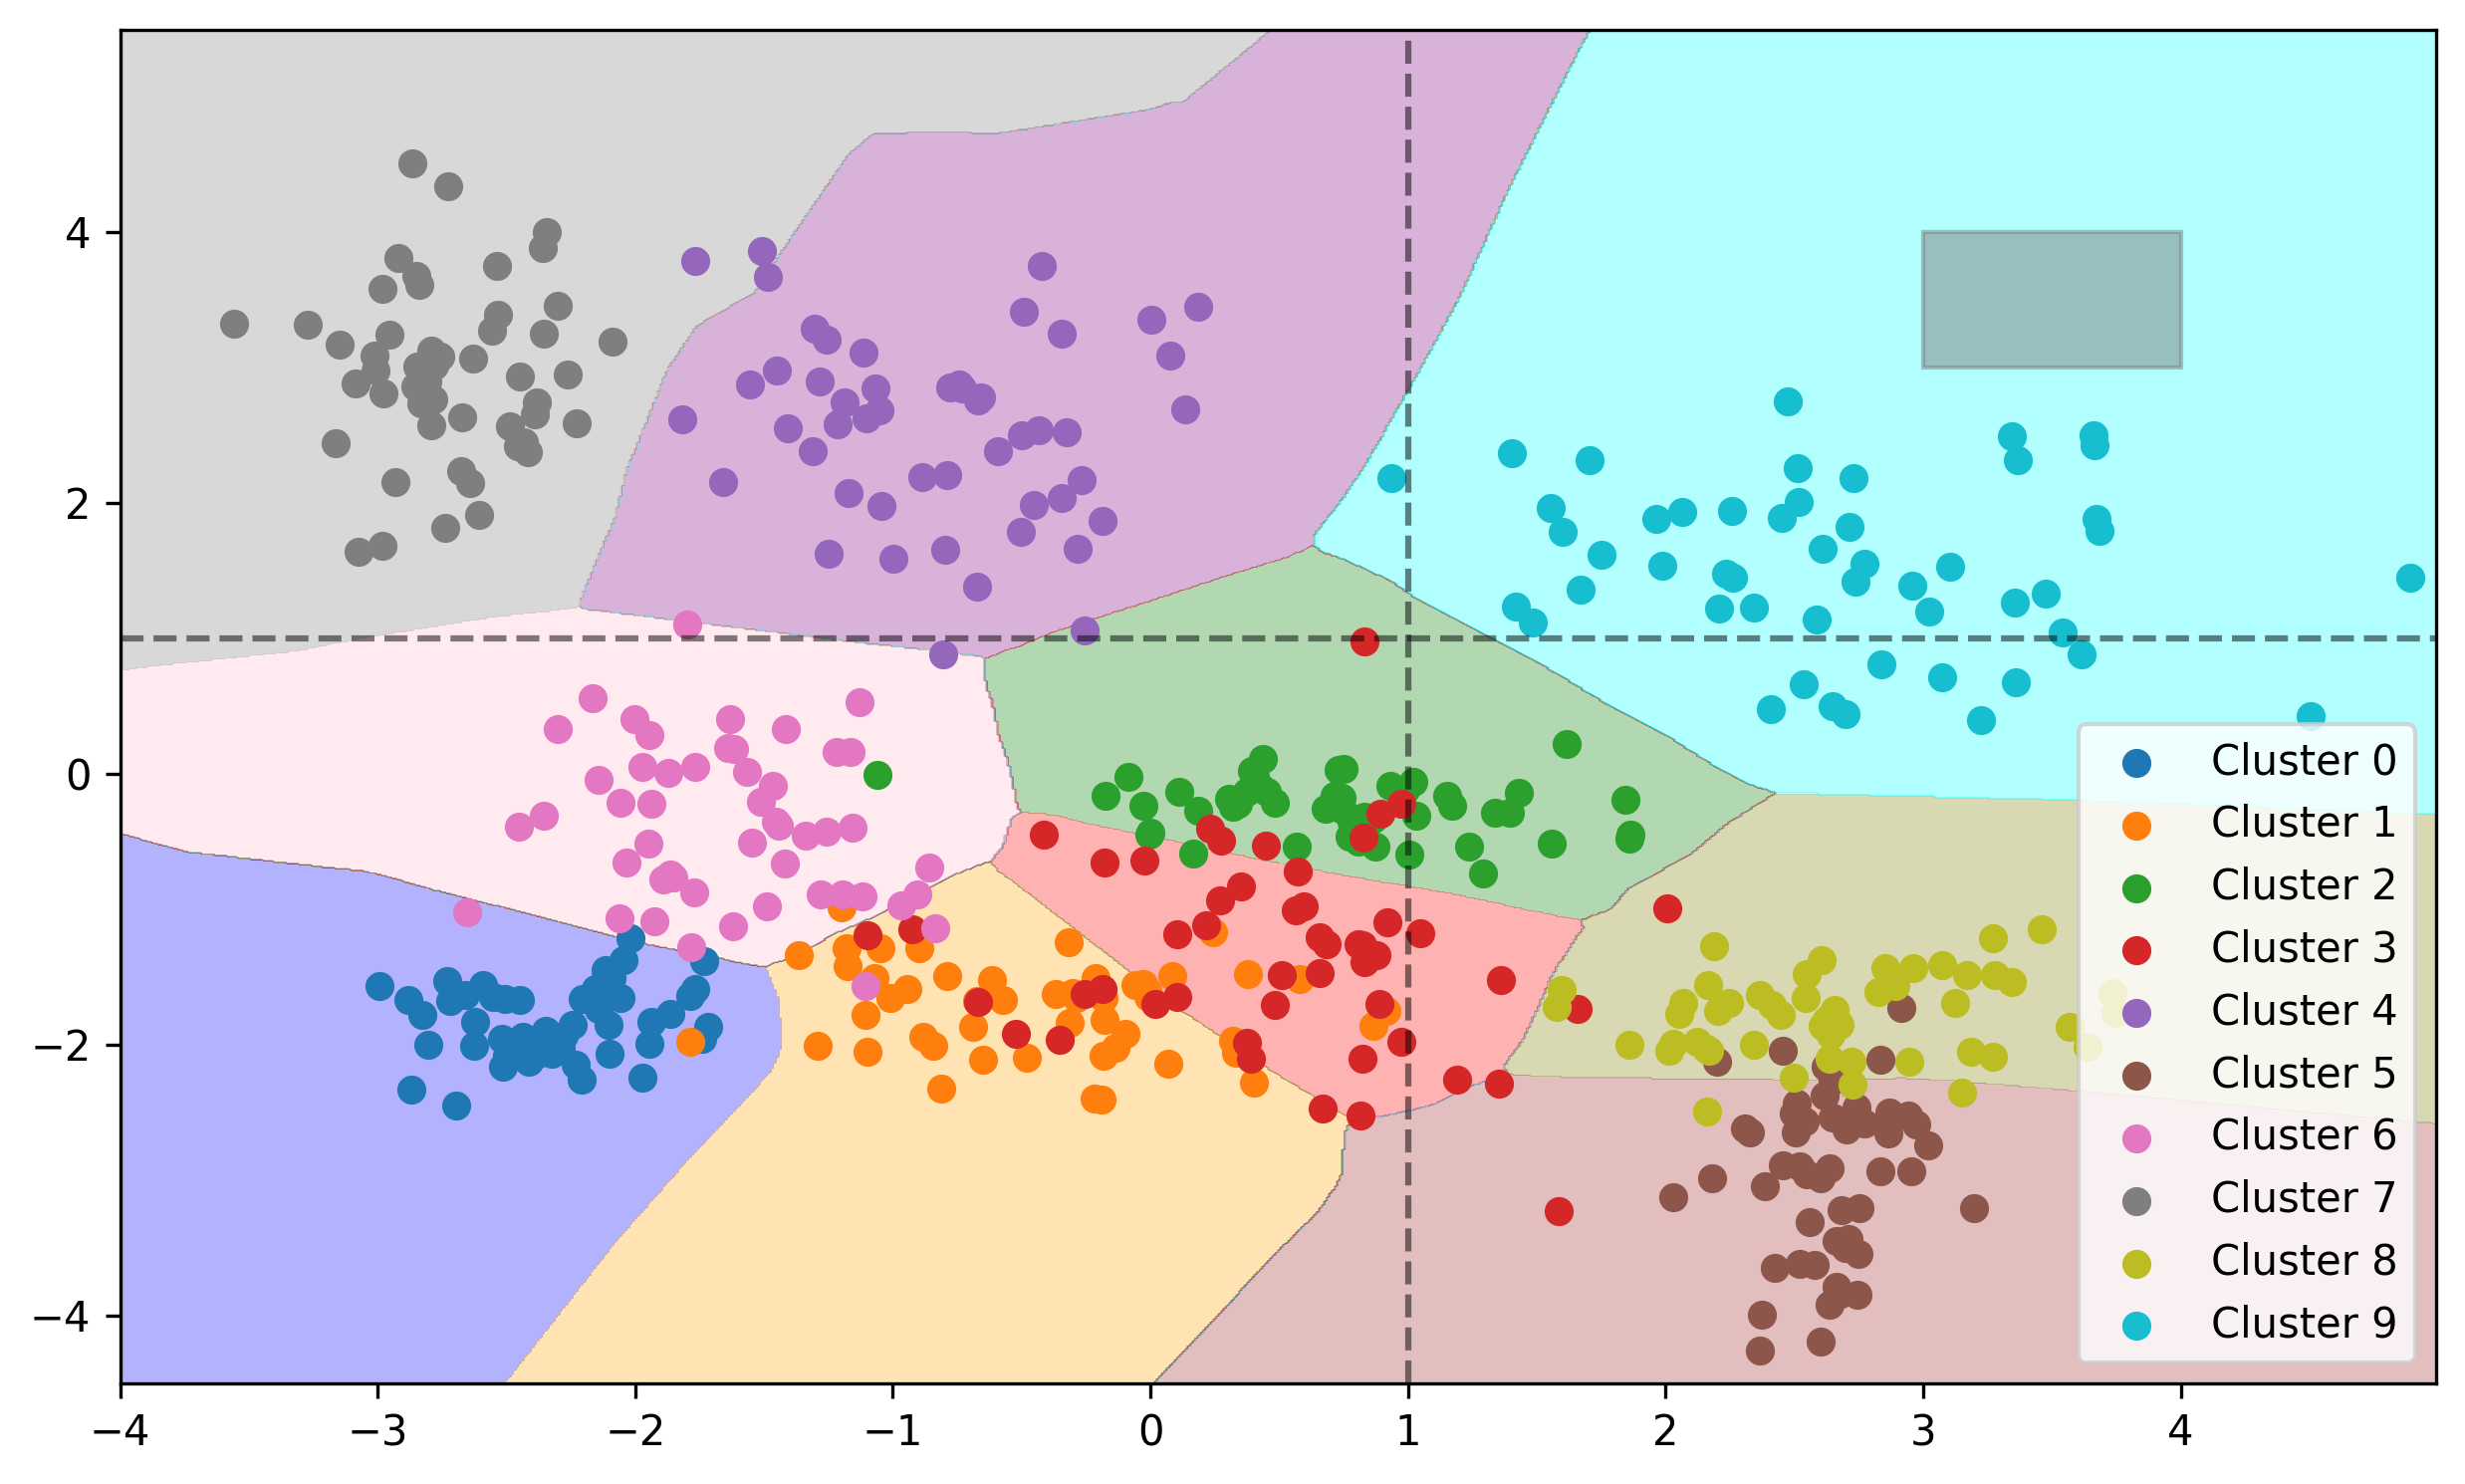

In [21]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
ax.add_patch(rect)
for i in range(len(means)):
    points_in_clusters = int(len(clusters) / len(means))
    start = i * points_in_clusters
    end = (i + 1) * points_in_clusters
    ax.scatter(
        clusters[start:end, 0], clusters[start:end, 1], label=f"Cluster {i}", zorder=1
    )
plt.axhline(y=1, color='black', linestyle='--', alpha=0.5)
plt.axvline(x=1, color='black', linestyle='--', alpha=0.5)


ax.contourf(xx, yy, Z, alpha=0.3, zorder=-1,levels=11, colors=("blue","orange",'green','red', 'purple','cyan','brown','pink','gray','olive', 'cyan', 'cyan'))
plt.legend()
plt.show()

## Importance Sampling
We need to compute the value and variance of:
* $V_{IS}$
* $V_{PDIS}$
* $V_{IS}^{concept}$
* $V_{PDIS}^{concept}$

Intuitively, a conceptual region covers more area in the state space and hence there should be more overlap between the behavioural and evaluation policies, and therefore less variance. Note that certain concepts may result in less variance while others may not. We will then need to optimise over the concepts to find the set which reduce the variance the most.

The below formulation is of per-decision importance sampling (PDIS). We need to construct the formulation of vanilla IS too. 

$$
\hat{V}_{IS}^{\pi_e}(\mathcal{D}) = \frac{1}{|\mathcal{D}|}\sum_{\tau \in \mathcal{D}} g(\tau)\rho(\tau)
$$
where
$$
\rho(\tau) = \prod_{t=1}^{T}\frac{\pi_e(a_t|s_t)}{\pi_b(a_t|s_t)}
$$
and
$$
g(\tau) = \sum_{t=1}^{T} \gamma^{t-1}r_t.
$$

Here $\gamma$ is the discount factor and $\tau \sim \pi_b$

In [5]:
unique_concept_combinations_visited = []

for comb in unique_concepts:
    if comb not in unique_concept_combinations_visited:
        unique_concept_combinations_visited.append(comb)
print(f"Number of unique concept combinations visited {len(unique_concept_combinations_visited)}")
mean_reward_per_combination = np.zeros(len(unique_concept_combinations_visited))
combination_occurence = np.zeros(len(unique_concept_combinations_visited))
unique_concept_combinations_visited

concepts_to_trajectories_mapping = {}
for combination in unique_concepts:
    concepts_to_trajectories_mapping[tuple(combination)] = []


for idx, concept_list in enumerate(unique_concepts):
    concepts_to_trajectories_mapping[tuple(concept_list)].append(idx)

print(concepts_to_trajectories_mapping.keys())
len(concepts_to_trajectories_mapping[(0, 2, 4, 6, 9)]) #try (0,1,3) (good) and (0,4) (bad)

Number of unique concept combinations visited 28
dict_keys([(0, 2, 4, 6, 9), (1, 2, 3, 4, 6, 9), (2, 4, 7, 9), (0, 2, 4, 6, 7, 9), (2, 4, 6, 7, 9), (2, 5, 8, 9), (1, 2, 4, 6, 9), (2, 3, 5, 9), (1, 2, 3, 4, 9), (1, 2, 3, 9), (1, 2, 3, 6, 9), (5, 8, 9), (2, 3, 5, 8, 9), (0, 1, 2, 4, 6, 9), (0, 2, 6, 9), (4, 7, 9), (1, 2, 6, 9), (0, 1, 2, 3, 9), (1, 2, 3, 8, 9), (0, 2, 3, 6, 9), (0, 1, 2, 6, 9), (2, 3, 4, 5, 8, 9), (1, 2, 3, 5, 9), (0, 1, 2, 3, 6, 9), (3, 5, 8, 9), (0, 4, 6, 9), (0, 1, 2, 3, 4, 6, 9), (4, 6, 7, 9)])


1023

In [ ]:
def plot_trajectories(trajectories, means, clusters):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    for history in trajectories:
        plt.plot(history[:, 0], history[:, 1])

    rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
    ax.add_patch(rect)
    for i in range(len(means)):
        points_in_clusters = int(len(clusters) / len(means))
        start = i * points_in_clusters
        end = (i + 1) * points_in_clusters
        plt.scatter(
            clusters[start:end, 0], clusters[start:end, 1], label=f"Cluster {i}"
        )

    plt.legend()
    plt.show()


trajectory_subset = trajectories[
    list(
        set(
            concepts_to_trajectories_mapping[(0, 2, 3, 4)]
            + concepts_to_trajectories_mapping[(0, 1, 2, 3, 4)]
            + concepts_to_trajectories_mapping[(0, 2, 3)]
            + concepts_to_trajectories_mapping[(0, 1, 2, 3)]
            + concepts_to_trajectories_mapping[(0, 1, 3, 4)]
          
        )
    )
]
plot_trajectories(trajectory_subset, means, clusters)
print(len(trajectory_subset))

In [8]:
input = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
input2 = concept_model.predict(np.array([-3,3]).reshape(1,2))[0]
print(pi_b.predict(np.array([-2,2]).reshape(1,2)))
print(input)
print(input2)
index = np.argmax(input2)

input2 = (np.where(input2 == np.max(input2),1,0))
print(input2)
print("concept: ", np.argmax(input2))
print(pi_b_c.predict(np.array(input).reshape(1,len(input)))) #action probability distribution for a given concept
print(pi_b_c.predict(np.array(input2).reshape(1,len(input))))
# np.mean(pi_b_c.predict(Xc_test), axis=0) #[0.45344904 0.09541331 0.35941267 0.09172497] on new dataset, [0.55403537 0.07854813 0.28875828 0.07865817] under original pi_b_c

[[0.22891605 0.20006742 0.49564493 0.07537158]]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 2.942335e-17
 0.000000e+00 5.023455e-20 1.000000e+00 0.000000e+00 0.000000e+00]
[0 0 0 0 0 0 0 1 0 0]
concept:  7
[[0.2316425  0.20006989 0.50063944 0.06764828]]
[[0.20880166 0.21061555 0.512436   0.06814685]]


In [254]:

def pre_process(trajectories_original, actions_original, concepts_original, concept_model=None, pi_b=None,  pi_b_c=None, concept_mapping=None, concept_path=None):
    behaviour_distributions = []
    evaluation_distributions = []
    action_indicies = []
    observed_concepts = []
    trajectories = copy.deepcopy(trajectories_original)
    actions = copy.deepcopy(actions_original)
    concepts = copy.deepcopy(concepts_original)

    subset_indicies = []
    if concept_mapping:
        for path in concept_path:
            subset_indicies += concept_mapping[path]
        subset_indicies = list(set(subset_indicies))
        trajectories = trajectories[subset_indicies] #selects subset of trajectories which travelled through a certain path of concepts
        actions = actions[subset_indicies]
        concepts = concepts[subset_indicies]
        

    print("Pre-processing data....")
    for idx in tqdm(range(len(trajectories))):
        completed_actions = actions[idx]
        observed_concept_path = concepts[idx]
        trajectory = trajectories[idx]
        action_indicies.append(actions_to_action_indexes(completed_actions))
        # observed_concepts.append(observed_concept_path)

        if concept_model is not None:
            predicted_concepts = predict_concepts_from_states(trajectory, concept_model)
            observed_concepts.append(np.argmax(predicted_concepts, axis=1))
            behaviour_distributions.append(predict_actions_from_concepts(predicted_concepts, pi_b_c))
        else:
            behaviour_distributions.append(predict_actions_from_states(trajectory, pi_b))
    
    evaluation_distributions = copy.deepcopy(behaviour_distributions)
    print("Finished.")
    return behaviour_distributions, evaluation_distributions, action_indicies, trajectories, subset_indicies, observed_concepts


def actions_to_action_indexes(actions):
    up = [0, 1]
    down = [0, -1]
    right = [1, 0]
    left = [-1, 0]
    A = np.array([up, down, right, left]) #action space
    '''Returns the index of the action in the state space, e.g. 0 for up, 1 for right etc'''
    return np.array([np.where(np.all((A == a), axis=1))[0][0] for a in actions])

def predict_concepts_from_states(trajectory, concept_model):
    return np.array(concept_model.predict(trajectory))

def predict_actions_from_states(trajectory, pi_b):
    return np.array(pi_b.predict(trajectory)) 
    # self.evaluation_distributions = np.copy(self.behaviour_distributions)

def predict_actions_from_concepts(concepts, pi_b_c):
    # concepts = [np.where(c == np.max(c),1,0).tolist() for c in concepts] #create one hot encoding
    return np.array(pi_b_c.predict(concepts))


class Estimator():

    up = [0, 1]
    down = [0, -1]
    right = [1, 0]
    left = [-1, 0]
    A = np.array([up, down, right, left]) #action space

    def __init__(self, trajectories_subset, concepts_subset, behaviour_distributions, evaluation_distributions, action_indicies, *args, **kwargs):
        self.trajectories = trajectories_subset
        self.concepts = concepts_subset
        self.behaviour_distributions = copy.deepcopy(behaviour_distributions)
        self.evaluation_distributions = copy.deepcopy(evaluation_distributions)
        self.action_indicies = copy.deepcopy(action_indicies)
        self.args = args
        self.kwargs = kwargs

    def IS():
        pass

    def PDIS(self, D, eval_policy):   
        value_estimate = 0
        on_policy_value = 0
        total_likelihood_ratios=0
        non_unit_likelihood_ratios=0
        vanishing_products = 0
        observed_evaluation_distributions = []

        #sample D trajectories from the dataset
        indicies = np.random.choice(len(self.trajectories), D, replace=False)

            
        for t in indicies: #loop through sampled trajectories
            behaviour_dist = self.behaviour_distributions[t]
            behaviour_trajectory = self.trajectories[t]
            evaluation_dist = self.evaluation_distributions[t]
            action_idxs = self.action_indicies[t]
            observed_concepts = self.concepts[t]
            T = len(behaviour_dist) #trajectory length

            product, count, evaluation_distributions_copy, cum_ratios = self.rho(behaviour_trajectory, observed_concepts, action_idxs, behaviour_dist, evaluation_dist, eval_policy)
            sum = self.g(T)

            PDIS=True
            if PDIS:
                value_estimate += np.sum(cum_ratios)*-1
            else:
                value_estimate += sum  * product

            on_policy_value += sum
            non_unit_likelihood_ratios+= count
            total_likelihood_ratios += T
            observed_evaluation_distributions.append(evaluation_distributions_copy)
            if product > 2:
                vanishing_products+=1
            

        return value_estimate/D, (non_unit_likelihood_ratios/total_likelihood_ratios)*100, on_policy_value/D, observed_evaluation_distributions, vanishing_products

    def rho(self, behaviour_trajectory, observed_concepts, actions_idx, behaviour_dist, evaluation_dist, eval_policy):
        product = 1
        count = 0

        r,_ = behaviour_dist.shape
        behaviour_probabilities = behaviour_dist[np.arange(r), actions_idx]
        evaluation_dist_copy = copy.deepcopy(evaluation_dist)
        
        for j in range(len(evaluation_dist)):
            x = behaviour_trajectory[j][0]
            y = behaviour_trajectory[j][1]
            c = observed_concepts[j]

            eval_policy = self.eval_policy_by_concept(c)
          
            if c in [0]:   # x < 1 and y < 1:  #evaluation policy
                epsilon = 0.2
                dist_index = np.random.choice([0,1],1,p=[1-epsilon,epsilon])[0]
                if dist_index == 1:
                    evaluation_dist_copy[j] = eval_policy 
        

        r,_ = evaluation_dist_copy.shape
        evaluation_probabilities = evaluation_dist_copy[np.arange(r), actions_idx]
        ratios = np.array(evaluation_probabilities/behaviour_probabilities)
        product = np.prod(ratios)
        count = len(np.where(ratios<0.8)[0])

        cum_ratios = np.cumprod(ratios) #for PDIS
        
        return product, count, evaluation_dist_copy, cum_ratios

    def g(self, T, gamma=1):
        r_t = -1
        return T*r_t
    
    def eval_policy_by_concept(self, c):
        if c == 0:
            return np.array([0.49, 0.01, 0.49, 0.01])
        elif c == 1:
            return np.array([0.53, 0.02, 0.35, 0.1])
        elif c == 2:
            return np.array([0.2, 0.2, 0.58, 0.02])
        else:
            return np.array([0.7, 0.0, 0.3, 0])
    

In [209]:
concept_model = keras.models.load_model('saved_models/c_4_optimised|s')
pi_b_c = keras.models.load_model('saved_models/pi_b_c_optimised')

In [210]:
paths = [(0, 2, 3, 4), (0, 1, 2, 3, 4), (0, 2, 3), (0, 1, 2, 3), (0, 1, 3, 4)]
(
    behaviour_distributions,
    evaluation_distributions,
    action_indicies,
    trajectories_subset,
    subset_indicies,
    concepts_subset
) = pre_process(
    trajectories[0:2000],
    actions,
    concepts,
    None,
    pi_b,
    None,
    concept_mapping=None,
    concept_path=paths,
)
(
    behaviour_distributions_c,
    evaluation_distributions_c,
    action_indicies_c,
    trajectories_subset_c,
    subset_indicies,
    concepts_subset
) = pre_process(
    trajectories[0:2000],
    actions,
    concepts,
    concept_model,
    pi_b,
    pi_b_c,
    concept_mapping=None,
    concept_path=paths,
)

print("Dataset size: ", len(behaviour_distributions))

Pre-processing data....



Finished.
Pre-processing data....



Finished.
Dataset size:  2000


In [90]:
print(concepts_subset[11])

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [3]:
d1 = np.array([0.7,0,0.3,0])
d2 = np.array([0.55, 0, 0.35, 0.1])
# d3 = np.array([0.2, 0.2, 0.6, 0])
d_ave = np.mean(np.array([d1,d2]), axis=0)
print(d_ave)

[0.625 0.    0.325 0.05 ]


In [255]:
def reject_outliers(data, m = 5.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    # print(s)
    return data[s<m]

estimator = Estimator(trajectories_subset=trajectories_subset, concepts_subset=concepts_subset, behaviour_distributions=behaviour_distributions, evaluation_distributions=evaluation_distributions, action_indicies=action_indicies)
concept_estimator = Estimator(trajectories_subset=trajectories_subset, concepts_subset=concepts_subset, behaviour_distributions=behaviour_distributions_c, evaluation_distributions=evaluation_distributions_c, action_indicies=action_indicies)

dataset_sizes = [1000, 2000]
dataset_sizes = [100, 300, 500, 700, 900]
num_trials = 100
data = {}
data_no_outliers = {}

for D in dataset_sizes:
    values1, values2, ess_values1, ess_values2, vanishing, vanishing_c = [], [], [], [], [], []
    for i in tqdm(range(num_trials)): 
        eval_policy = [0.55, 0, 0.35, 0.1] #The concept eval policy which was optimised
        estimate_concepts, small_weights_concepts, on_policy_value_concepts, observed_evaluation_distributions_concepts, vanishing_products_c = concept_estimator.PDIS(D, eval_policy=eval_policy)
        estimate, small_weights, on_policy_value, observed_evaluation_distributions, vanishing_products = estimator.PDIS(D, eval_policy=eval_policy)
        values1.append(estimate)
        values2.append(estimate_concepts)
        ess_values1.append(small_weights)
        ess_values2.append(small_weights_concepts)
        vanishing.append(vanishing_products)
        vanishing_c.append(vanishing_products_c)
    values1 = np.array(values1)
    values2 = np.array(values2)
    data[f"{D}_vanilla"] = values1
    data[f"{D}_concepts"] = values2
    data_no_outliers[f"{D}_vanilla"] = reject_outliers(values1)
    data_no_outliers[f"{D}_concepts"] = reject_outliers(values2)
    print(f"Mean weights smaller than 0.8: {np.array(ess_values1).mean()}%")
    print(f"Mean weights smaller than 0.8 concepts: {np.array(ess_values2).mean()}%")
    print(f"Mean weights > 2: {np.array(vanishing).mean()}")
    print(f"Mean weights > 2 concepts: {np.array(vanishing_c).mean()}")
    print("On policy: ", on_policy_value)
    print("On policy over concepts: ", on_policy_value_concepts)


Mean weights smaller than 0.8: 1.43630175592572%
Mean weights smaller than 0.8 concepts: 1.429813364402772%
Mean weights > 2: 5.48
Mean weights > 2 concepts: 5.48
On policy:  -467.06
On policy over concepts:  -476.19



Mean weights smaller than 0.8: 1.422728339262446%
Mean weights smaller than 0.8 concepts: 1.4316812271981088%
Mean weights > 2: 16.02
Mean weights > 2 concepts: 16.12
On policy:  -481.13
On policy over concepts:  -472.29


KeyboardInterrupt: 

In [71]:
def calulcate_on_polcy_value(D, trajectories):
    num_trials = 100
    on_policy_estimates = np.zeros((num_trials))
    for k in range(num_trials):
        indicies = np.random.choice(len(trajectories), D, replace=False)
        sampled_trajectories = trajectories[indicies]
        for i,traj in enumerate(sampled_trajectories):
            on_policy_estimates[k] += len(traj)*-1
        on_policy_estimates[k] = on_policy_estimates[k]/D #take mean
    on_policy_value = np.mean(on_policy_estimates)
    var_on_policy = np.var(on_policy_estimates)
    return on_policy_value, var_on_policy, num_trials

# on_policy_value, var_on_policy = calulcate_on_polcy_value(100, trajectories_subset)
# print("On policy value: ", on_policy_value)
# print("Variance of on policy value: ", var_on_policy)

on_policy_data = {}
for D in dataset_sizes:
    on_policy_data[f"{D}_on_policy_value"] , on_policy_data[f"{D}_on_policy_variance"], on_policy_data["N"]  = calulcate_on_polcy_value(D, trajectories_subset)
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in on_policy_data.items() ]))
print(df)

   100_on_policy_value  100_on_policy_variance    N  300_on_policy_value  \
0             -475.564                49.08457  100             -475.772   

   300_on_policy_variance  500_on_policy_value  500_on_policy_variance  
0               17.578684           -476.31996                7.720243  


In [ ]:
index = 3
for i in range(0,150):
    print(behaviour_distributions_c[index][i], behaviour_distributions[index][i], concepts_subset[index][i])

In [258]:
# data = {"vanilla":values1,"concepts":values2, "vanilla_no_outliers":reject_outliers(values1),"concepts_no_outliers":reject_outliers(values2)}
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in data.items() ]))
df_no_outliers = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in data_no_outliers.items()]))

print("With outliers")
print(df.describe())
print("Without outliers")
print(df_no_outliers.describe())

With outliers
       100_vanilla  100_concepts  300_vanilla  300_concepts
count   100.000000    100.000000   100.000000    100.000000
mean   -465.543312   -459.966167  -488.199393   -468.190131
std      74.859876     75.456948    76.407189     41.506705
min    -931.746008   -790.057547 -1111.689421   -614.901989
25%    -494.816447   -500.990925  -506.276407   -491.400378
50%    -451.505856   -445.551776  -481.278829   -465.462493
75%    -418.418746   -407.559829  -451.915135   -435.620910
max    -366.664355   -337.606985  -386.463042   -393.355423
Without outliers
       100_vanilla  100_concepts  300_vanilla  300_concepts
count    98.000000     99.000000    99.000000     99.000000
mean   -458.561014   -456.631910  -481.901514   -466.708193
std      54.216265     68.035137    43.483671     38.968336
min    -614.649116   -658.986905  -605.315225   -571.305152
25%    -488.323053   -497.552889  -506.079988   -491.083221
50%    -450.563449   -445.306042  -481.046980   -465.425502
75%    -4

- Can we confidently say a bad policy is bad?
- Can we confidently say a good policy is good?
- Can we identify good sets of concepts and bad sets of concepts?

The above is key to figure out what types of concepts lead to a) better returns but more importantly which types of concepts lead to b) better bias variance guarantees

In some previous experimentation, I couldn't really say what policy was good or not since they started from different initial states, and I was only
looking at trajectories starting in one of the three states. What I was doing is completely valid, but the results were not clearly comparable to the on policy value, 
making it difficult to tell if a policy is actually good or not.

In [ ]:
df.to_parquet("parquets/concept_experiments/optimised/ope_estimates_c0_eps02")
df_no_outliers.to_parquet("parquets/concept_experiments/optimised/ope_estimates_c0_eps02_no_outliers")

In [167]:
num_concepts = len(means)
eval_env = WindyGridworld(
    num_concepts=num_concepts,
    method="simple",
    knn=knn,
    means=means,
    policy_model=pi_b,
    concept_model=None,
    epsilon=0.3,
    eval_epsilon=0.7,
    eval_distribution= [0,0,1,0] # [0.15, 0.25, 0.51, 0.09], 
)

eval_trajectories = []
eval_rewards = []
eval_unique_concepts = []
eval_concepts = []
eval_actions = []


# Create evaluation trajectories in windy gridworld
for j in tqdm(range(30)):
    starting_positions = [np.array([-3, -3]), np.array([-4, 2]), np.array([1, -3])]
    s = starting_positions[np.random.choice([0,1],1)[0]]
    eval_env.play(
        True,
        eval_trajectories,
        eval_rewards,
        eval_unique_concepts,
        eval_concepts,
        eval_actions,
        s=s,
        use_eval_policy=True,
    )

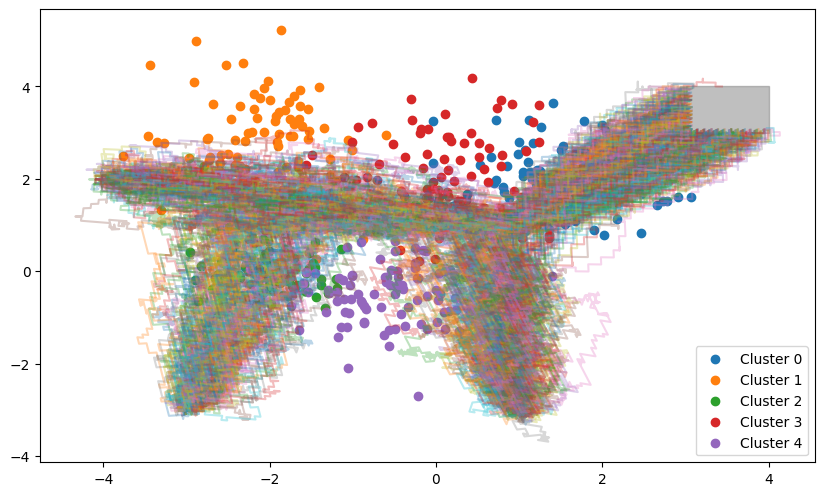

In [683]:
def plot_eval_trajectories(eval_trajectories,trajectories):
    fig, ax = plt.subplots(figsize=(10,6), dpi=100)
    
    
    for history in trajectories:
        plt.plot(history[:, 0], history[:, 1], alpha=0.3)

    # for history in eval_trajectories:
    #     plt.plot(history[:, 0], history[:, 1], color="magenta")
    # plt.plot(history[0, 0], history[0, 1], color="magenta", label="Evaluation Trajectory") #for legend purposes

    rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
    ax.add_patch(rect)
    for i in range(len(means)):
        num_points = int(len(clusters)/len(means))
        start = i*num_points
        end = (i+1)*num_points
        plt.scatter(clusters[start:end,0], clusters[start:end,1], label=f"Cluster {i}")

    plt.legend(loc="lower right")
    plt.show()

plot_eval_trajectories(eval_trajectories, trajectories_subset[np.random.choice(len(trajectories_subset), 500, replace=False)])

In [169]:
lengths = np.array([len(eval_traj) for eval_traj in eval_trajectories])
indicies = [eval_traj[0][0]<-3.5 for eval_traj in eval_trajectories]
print(lengths[indicies])
print(np.array(lengths[indicies]).mean())
print(np.array(eval_unique_concepts)[indicies])

[297 244 270 198 290 316 393 248 216 212 249]
266.6363636363636
[list([0, 1, 3]) list([0, 1, 3]) list([0, 1, 3]) list([0, 1, 3])
 list([0, 1, 3]) list([0, 1, 3, 4]) list([0, 1, 3, 4]) list([0, 1, 3])
 list([0, 1, 3]) list([0, 1, 2, 3]) list([0, 1, 3])]


<ipython-input-169-67de2488713c>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(eval_unique_concepts)[indicies])
